# Dueling DQN in PyTorch Lightning (Random Mode)

Epoch 0, Loss: 116.50575256347656
Epoch 100, Loss: 64.9923095703125
Epoch 200, Loss: 173.77120971679688
Epoch 300, Loss: 36.53168487548828
Epoch 400, Loss: 195.15992736816406
Epoch 500, Loss: 32.068058013916016
Epoch 600, Loss: 28.781421661376953
Epoch 700, Loss: 176.8009490966797
Epoch 800, Loss: 27.517501831054688
Epoch 900, Loss: 158.28720092773438
Epoch 1000, Loss: 25.16147804260254
Epoch 1100, Loss: 48.95076370239258
Epoch 1200, Loss: 234.79212951660156
Epoch 1300, Loss: 131.6024932861328
Epoch 1400, Loss: 109.80672454833984
Epoch 1500, Loss: 105.2344970703125
Epoch 1600, Loss: 82.11136627197266
Epoch 1700, Loss: 69.97832489013672
Epoch 1800, Loss: 98.00821685791016
Epoch 1900, Loss: 60.271728515625
Epoch 2000, Loss: 84.4963607788086
Epoch 2100, Loss: 35.46636199951172
Epoch 2200, Loss: 59.86280059814453
Epoch 2300, Loss: 2.9649691581726074
Epoch 2400, Loss: 11.47193431854248
Epoch 2500, Loss: 214.91319274902344
Epoch 2600, Loss: 99.90599060058594
Epoch 2700, Loss: 7.6378793716430

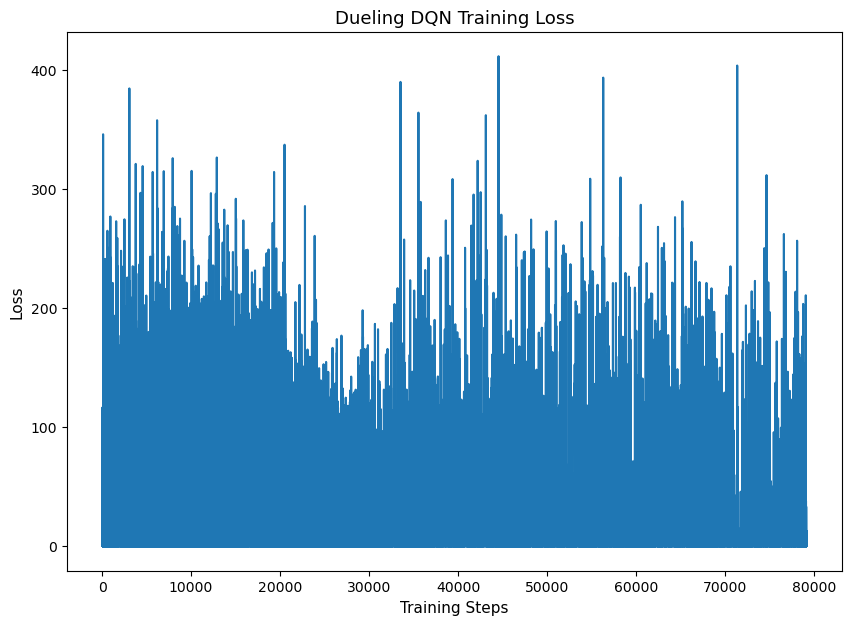

In [87]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from Gridworld import Gridworld
import pytorch_lightning as pl
from collections import deque
# 網路設定
L1 = 64
L2 = 150
L3 = 100
L4 = 4  # Number of actions

# Dueling DQN 網路定義
class DuelingDQN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DuelingDQN, self).__init__()
        # Shared layers
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)

        # Value stream
        self.value_fc = torch.nn.Linear(hidden_size, 1)

        # Advantage stream
        self.advantage_fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        value = self.value_fc(x)
        advantage = self.advantage_fc(x)

        # Combine value and advantage
        q_values = value + (advantage - advantage.mean())
        return q_values

# Create the model
model = DuelingDQN(L1, L2, L4)

# Define loss and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training parameters
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration factor

# Action set
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r'
}

# Store losses for plotting
losses = []
memory = deque(maxlen=10000)

# Training function
def train_dueling_dqn():
    global epsilon
    epochs = 10000  # Number of epochs
    for epoch in range(epochs):
        loss = None 
        game = Gridworld(size=4, mode='random')
        state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state1 = torch.from_numpy(state_).float()
        status = 1
        
        while status == 1:
            qval = model(state1)
            qval_ = qval.data.numpy()

            # epsilon-greedy policy
            if random.random() < epsilon:
                action_ = np.random.randint(0, 4)
            else:
                action_ = np.argmax(qval_)

            action = action_set[action_]
            game.makeMove(action)

            state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
            state2 = torch.from_numpy(state2_).float()
            reward = game.reward()

            # Training step
            next_qvals_online = model(state2.reshape(1, 64))  # Get Q-values from online model
            best_action = torch.argmax(next_qvals_online).item()  # Best action from online model

            next_qvals_target = model(state2.reshape(1, 64))  # Get Q-values from target model
            maxQ = next_qvals_target.squeeze()[best_action]

            if reward == -1:
                Y = reward + (gamma * maxQ)
            else:
                Y = reward

            Y = torch.Tensor([Y]).detach()
            X = qval.squeeze()[action_]

            loss = loss_fn(X, Y)  # Calculate the loss
            losses.append(loss.item())  # Append the loss for plotting

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state1 = state2

            if abs(reward) == 10:  # End condition
                status = 0
        
        # Reduce epsilon over time to shift from exploration to exploitation
        if epsilon > 0.1:
            epsilon -= (1/epochs)
        
        # Display progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    # Save the trained model
    torch.save(model.state_dict(), 'lighting_dueling_dqn_random_model.pth')

    # Plot loss curve
    plt.figure(figsize=(10, 7))
    plt.plot(losses)
    plt.xlabel("Training Steps", fontsize=11)
    plt.ylabel("Loss", fontsize=11)
    plt.title("Dueling DQN Training Loss", fontsize=13)
    plt.show()

# Run training
train_dueling_dqn()


# DuelingDQN + Target Network + Double DQN + Experience Replay Buffer + Epsilon-Greedy (指數衰減) in PyTorch Lightning (Random Mode)

Epoch 0, Loss: N/A, Epsilon: 0.995
Epoch 100, Loss: 0.8866511583328247, Epsilon: 0.603
Epoch 200, Loss: 0.5245256423950195, Epsilon: 0.365
Epoch 300, Loss: 0.4372604489326477, Epsilon: 0.221
Epoch 400, Loss: 0.3294987380504608, Epsilon: 0.134
Epoch 500, Loss: 0.2341880053281784, Epsilon: 0.100
Epoch 600, Loss: 0.3342370092868805, Epsilon: 0.100
Epoch 700, Loss: 0.13403569161891937, Epsilon: 0.100
Epoch 800, Loss: 0.3114415407180786, Epsilon: 0.100
Epoch 900, Loss: 0.31221529841423035, Epsilon: 0.100
Epoch 1000, Loss: 0.24340024590492249, Epsilon: 0.100
Epoch 1100, Loss: 0.6010643839836121, Epsilon: 0.100
Epoch 1200, Loss: 0.4321810305118561, Epsilon: 0.100
Epoch 1300, Loss: 0.20083211362361908, Epsilon: 0.100
Epoch 1400, Loss: 0.1405985951423645, Epsilon: 0.100
Epoch 1500, Loss: 0.16522665321826935, Epsilon: 0.100
Epoch 1600, Loss: 0.3081584572792053, Epsilon: 0.100
Epoch 1700, Loss: 0.313234806060791, Epsilon: 0.100
Epoch 1800, Loss: 0.21917858719825745, Epsilon: 0.100
Epoch 1900, Los

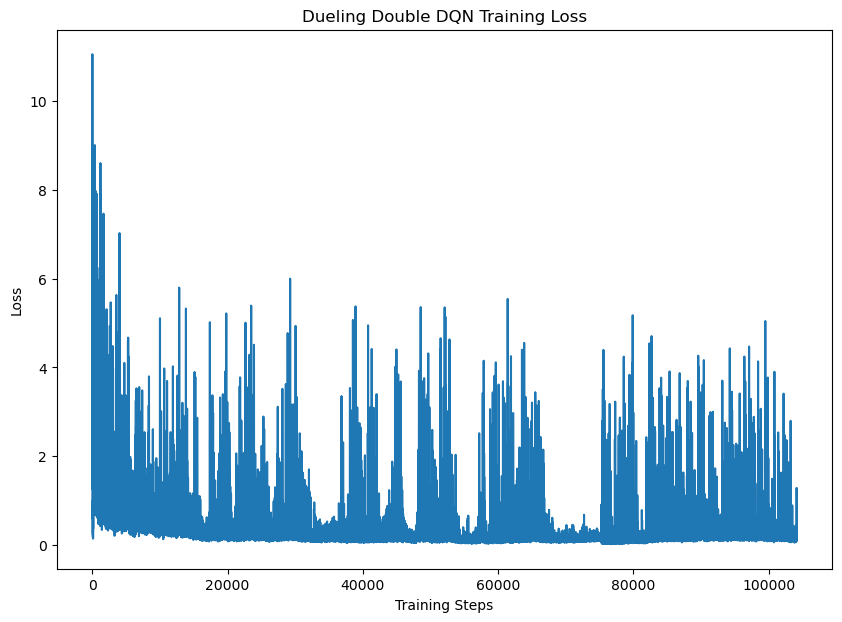

In [48]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from Gridworld import Gridworld
import pytorch_lightning as pl
from collections import deque

# 網路設定
L1 = 64
L2 = 150
L3 = 100
L4 = 4  # Number of actions

# Dueling DQN 網路定義
class DuelingDQN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DuelingDQN, self).__init__()
        # Shared layers
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        # Value stream
        self.value_fc = torch.nn.Linear(hidden_size, 1)
        # Advantage stream
        self.advantage_fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_fc(x)
        advantage = self.advantage_fc(x)
        q_values = value + (advantage - advantage.mean())
        return q_values

# 建立 online 與 target model
model = DuelingDQN(L1, L2, L4)
target_model = DuelingDQN(L1, L2, L4)
target_model.load_state_dict(model.state_dict())  # 初始化 target model

# 定義 loss 和 optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 訓練參數
gamma = 0.9
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995  # 指數衰減

# 更新 target model 參數的頻率
target_update_freq = 10

# 行動空間
action_set = {0: 'u', 1: 'd', 2: 'l', 3: 'r'}

# 儲存 loss 和 memory
losses = []
memory = deque(maxlen=10000)
batch_size = 64

# 訓練函數
def train_dueling_dqn():
    global epsilon
    epochs = 1000
    for epoch in range(epochs):
        loss = None 
        game = Gridworld(size=4, mode='random')
        state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state1 = torch.from_numpy(state_).float()
        status = 1

        while status == 1:
            qval = model(state1)
            qval_ = qval.data.numpy()
            if random.random() < epsilon:
                action_ = np.random.randint(0, 4)
            else:
                action_ = np.argmax(qval_)
            action = action_set[action_]

            game.makeMove(action)
            state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
            state2 = torch.from_numpy(state2_).float()
            reward = game.reward()
            done = abs(reward) == 10

            # 將經驗存入 replay buffer
            memory.append((state1, action_, reward, state2, done))
            state1 = state2

            if len(memory) >= batch_size:
                batch = random.sample(memory, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

                state_batch = torch.cat(state_batch)
                next_state_batch = torch.cat(next_state_batch)
                reward_batch = torch.tensor(reward_batch, dtype=torch.float32)
                action_batch = torch.tensor(action_batch)
                done_batch = torch.tensor(done_batch, dtype=torch.float32)

                # current Q value
                qvals = model(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze()

                # Double DQN：使用 online model 選動作，target model 評估 Q 值
                next_qvals_online = model(next_state_batch)
                best_actions = torch.argmax(next_qvals_online, dim=1)
                next_qvals_target = target_model(next_state_batch)
                max_qvals = next_qvals_target.gather(1, best_actions.unsqueeze(1)).squeeze()

                expected_qvals = reward_batch + gamma * max_qvals * (1 - done_batch)

                loss = loss_fn(qvals, expected_qvals.detach())
                losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                status = 0

        # 指數衰減 epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # 定期更新 target network
        if epoch % target_update_freq == 0:
            target_model.load_state_dict(model.state_dict())

        # 每 100 輪印出一次進度
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item() if loss else 'N/A'}, Epsilon: {epsilon:.3f}")

    # 儲存模型
    torch.save(model.state_dict(), 'dueling_dqn_double_model.pth')

    # 畫出 loss 曲線
    plt.figure(figsize=(10, 7))
    plt.plot(losses)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Dueling Double DQN Training Loss")
    plt.show()

# 執行訓練
train_dueling_dqn()


# DuelingDQN + Target Network + Double DQN + Experience Replay Buffer + Epsilon-Greedy (指數衰減) + 防撞墻機制 in PyTorch Lightning (Random Mode)

Epoch 0, Loss: N/A, Epsilon: 1.000, Avg Reward: 0.000
Epoch 100, Loss: 0.04078279808163643, Epsilon: 0.872, Avg Reward: -12.720
Epoch 200, Loss: 0.02584221586585045, Epsilon: 0.698, Avg Reward: -15.220
Epoch 300, Loss: 0.028436090797185898, Epsilon: 0.576, Avg Reward: -6.930
Epoch 400, Loss: 0.012549346312880516, Epsilon: 0.436, Avg Reward: -8.760
Epoch 500, Loss: 0.007707315497100353, Epsilon: 0.307, Avg Reward: -4.700
Epoch 600, Loss: 0.0077282763086259365, Epsilon: 0.172, Avg Reward: -5.210
Epoch 700, Loss: 0.0074616121128201485, Epsilon: 0.050, Avg Reward: -14.940
Epoch 800, Loss: 0.006866110023111105, Epsilon: 0.050, Avg Reward: -145.530
Epoch 900, Loss: 0.0027292598970234394, Epsilon: 0.050, Avg Reward: -13.550
Epoch 1000, Loss: 0.0033103416208177805, Epsilon: 0.050, Avg Reward: 0.060
Epoch 1100, Loss: 0.0029312362894415855, Epsilon: 0.050, Avg Reward: -14.300
Epoch 1200, Loss: 0.0027282724622637033, Epsilon: 0.050, Avg Reward: -8.880
Epoch 1300, Loss: 0.003931380342692137, Epsil

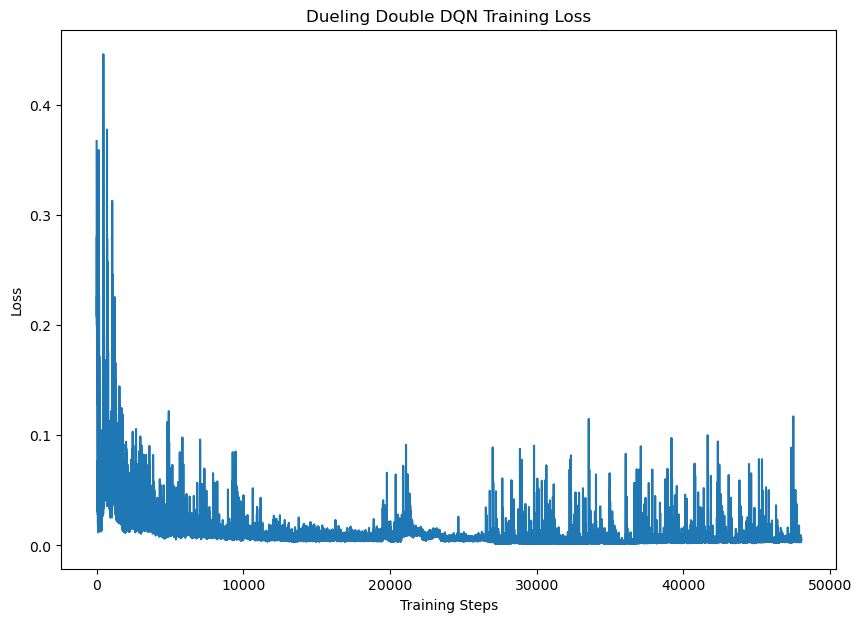

In [83]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from Gridworld import Gridworld
import pytorch_lightning as pl
from collections import deque

# Network configuration
L1 = 64
L2 = 256
L3 = 200
L4 = 4  # Number of actions

# Dueling DQN network definition
class DuelingDQN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DuelingDQN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.value_fc = torch.nn.Linear(hidden_size, 1)
        self.advantage_fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_fc(x)
        advantage = self.advantage_fc(x)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

# Initialize models
model = DuelingDQN(L1, L2, L4)
target_model = DuelingDQN(L1, L2, L4)
target_model.load_state_dict(model.state_dict())

# Loss and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training parameters
gamma = 0.95
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_steps = 10000
target_update_freq = 20  # Increased for more stable updates
batch_size = 128
memory = deque(maxlen=20000)
action_set = {0: 'u', 1: 'd', 2: 'l', 3: 'r'}
wall_penalty = -0.2
exploration_bonus = 0.05
reward_scale = 5.0  # Reduced scaling factor for finer control

# Logging
losses = []
rewards = []
avg_rewards = []

def check_wall_collision(game, action, state):
    """Check if the action leads to a wall collision using board state."""
    board = state.reshape(4, 4, 4)
    player_channel = board[:, :, 0]  # Player in channel 0
    wall_channel = board[:, :, 3]    # Wall in channel 3
    player_pos = np.where(player_channel == 1)
    if len(player_pos[0]) == 0:
        return False
    x, y = player_pos[0][0], player_pos[1][0]

    if action == 'u' and x > 0 and wall_channel[x-1, y] == 1:
        return True
    if action == 'd' and x < 3 and wall_channel[x+1, y] == 1:
        return True
    if action == 'l' and y > 0 and wall_channel[x, y-1] == 1:
        return True
    if action == 'r' and y < 3 and wall_channel[x, y+1] == 1:
        return True
    return False

def train_dueling_dqn():
    epochs = 10000
    steps = 0
    best_avg_reward = -float('inf')
    patience = 500
    patience_counter = 0

    for epoch in range(epochs):
        loss = None
        episode_reward = 0
        game = Gridworld(size=4, mode='random')
        state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state1 = torch.from_numpy(state_).float()
        status = 1

        epsilon = max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (steps / epsilon_decay_steps))

        while status == 1:
            steps += 1
            qval = model(state1)
            qval_ = qval.data.numpy()
            if random.random() < epsilon:
                action_ = np.random.randint(0, 4)
            else:
                action_ = np.argmax(qval_)
            action = action_set[action_]

            if check_wall_collision(game, action, state_):
                reward = wall_penalty / reward_scale
                state2_ = state_
                done = False
            else:
                game.makeMove(action)
                state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
                reward = game.reward() / reward_scale
                done = abs(reward * reward_scale) == 10
                if not done and reward * reward_scale == 0:
                    reward += exploration_bonus / reward_scale

            state2 = torch.from_numpy(state2_).float()
            episode_reward += reward * reward_scale

            memory.append((state1, action_, reward, state2, done))
            state1 = state2

            if len(memory) >= batch_size:
                batch = random.sample(memory, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

                state_batch = torch.cat(state_batch)
                next_state_batch = torch.cat(next_state_batch)
                reward_batch = torch.tensor(reward_batch, dtype=torch.float32)
                action_batch = torch.tensor(action_batch)
                done_batch = torch.tensor(done_batch, dtype=torch.float32)

                qvals = model(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze()
                next_qvals_online = model(next_state_batch)
                best_actions = torch.argmax(next_qvals_online, dim=1)
                next_qvals_target = target_model(next_state_batch)
                max_qvals = next_qvals_target.gather(1, best_actions.unsqueeze(1)).squeeze()

                expected_qvals = reward_batch + gamma * max_qvals * (1 - done_batch)

                loss = loss_fn(qvals, expected_qvals.detach())
                losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            if done:
                status = 0
                rewards.append(episode_reward)

        if epoch % target_update_freq == 0:
            target_model.load_state_dict(model.state_dict())

        # Compute avg_reward safely
        avg_reward = np.mean(rewards[-100:]) if len(rewards) >= 100 else 0.0
        if len(rewards) >= 100:
            avg_rewards.append(avg_reward)
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                patience_counter = 0
                torch.save(model.state_dict(), 'dueling_dqn_double_model.pth')
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item() if loss else 'N/A'}, Epsilon: {epsilon:.3f}, Avg Reward: {avg_reward:.3f}")

    plt.figure(figsize=(10, 7))
    plt.plot(losses)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Dueling Double DQN Training Loss")


if __name__ == "__main__":
    train_dueling_dqn()

In [86]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
      print("Initial State:")
      print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_) 
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
      state = torch.from_numpy(state_).float()
      if display:
        print(test_game.display())
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 15): #若移動了15步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break    
    win = True if status == 2 else False
    print(win)
    return win

# 載入訓練過的模型
model.load_state_dict(torch.load('dueling_dqn_double_model.pth'))
model.eval()  # 切換到評估模式，這樣會停用隨機行為（例如 dropout）

max_games = 1000  # 測試1000場遊戲
wins = 0  # 記錄勝利次數

# 進行測試遊戲
for i in range(max_games):
    win = test_model(model, mode='random')  # 使用模型進行測試遊戲
    if win:
        wins += 1

# 計算並顯示勝率
win_perc = float(wins) / float(max_games)
print(f"Games played: {max_games}, # of wins: {wins}")
print(f"Win percentage: {100.0 * win_perc}%")

C:\Users\raced\AppData\Local\Temp\ipykernel_27960\653044602.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('dueling_dqn_double_model.p

Initial State:
[['-' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' 'P' '+']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: r
[['-' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True
Initial State:
[[' ' ' ' '+' ' ']
 ['W' ' ' '-' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: r
[[' ' ' ' '+' ' ']
 ['W' ' ' '-' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[[' ' ' ' '+' ' ']
 ['W' ' ' '-' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']]
Move #: 2; Taking action: u
[[' ' ' ' '+' ' ']
 ['W' ' ' '-' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: d
[[' ' ' ' '+' ' ']
 ['W' ' ' '-' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']]
Move #: 4; Taking action: r
[[' ' ' ' '+' ' ']
 ['W' ' ' '-' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'P']]
Move #: 5; Taking action: l
[[' ' ' ' '+' ' ']
 ['W' ' ' '-' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']]
Move #: 6; Taking action: u
[[' ' ' ' '+' ' ']
 ['W' ' 